---
**Author:** Miao Zhu

**Date:** March 25, 2024

## Description

"This Jupyter Notebook aims reproduce the major analysis in Fig. 6",

## Related Figures
+ Fig 6.
---

In [1]:
import pandas as pd
import numpy as np
import numba
import pylab
import cassiopeia as cas
import matplotlib.pyplot as plt

import scipy

%matplotlib inline

import seaborn as sns
sns.set_theme(style="ticks", rc = {"axes.spines.right": False, "axes.spines.top": False, "pdf.fonttype": 42})

In [2]:
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('retina')

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
import glob

dirs = glob.glob(r'/data1/home/gdpeng/mzhu/Project/293T/mNMO/data/*.h5ad', recursive=True)
dirs.sort(reverse=True)

In [5]:
dirs

['/data1/home/gdpeng/mzhu/Project/293T/mNMO/data/MnmpD3.h5ad',
 '/data1/home/gdpeng/mzhu/Project/293T/mNMO/data/MnmoD7.h5ad',
 '/data1/home/gdpeng/mzhu/Project/293T/mNMO/data/MnmoD15.h5ad']

In [6]:
sampleid = list(map(lambda x: x.split("/")[-1].split(".h5ad")[0], dirs))
sampleid.sort(reverse=True)
sampleid

['MnmpD3', 'MnmoD7', 'MnmoD15']

In [7]:
import scanpy as sc
adata_dict = dict(map(lambda x,y: (x, sc.read_h5ad(y)), sampleid, dirs))

/opt/conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


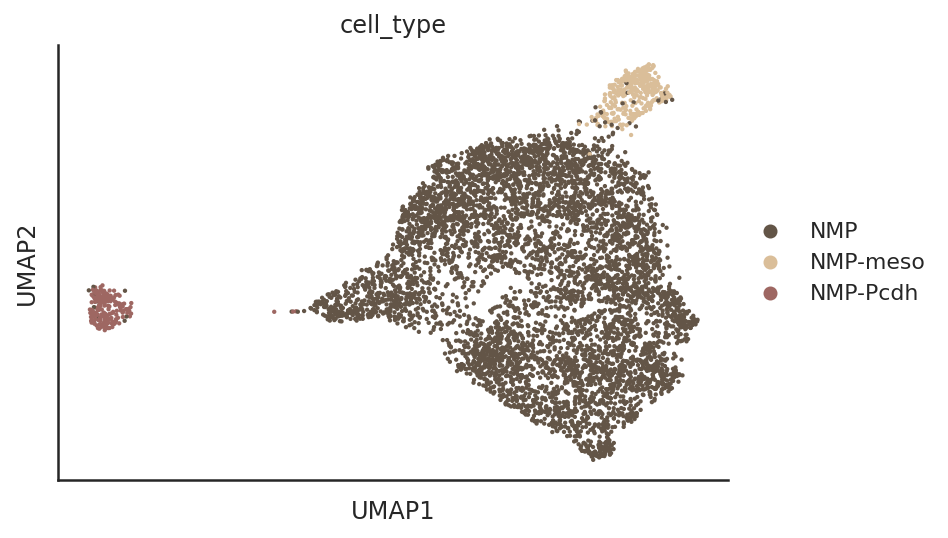

/opt/conda/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


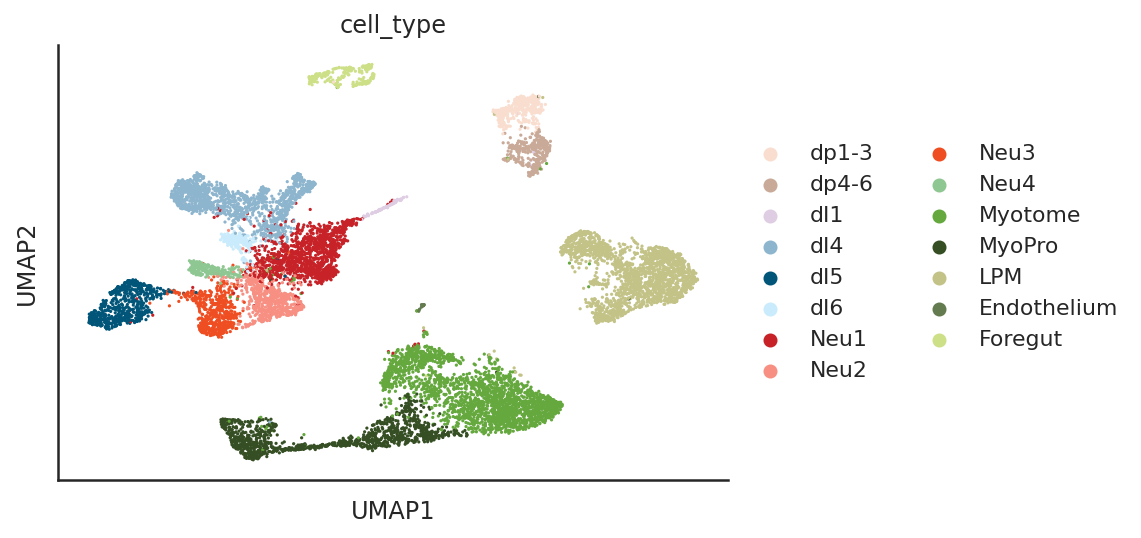

In [9]:
# for i in sampleid:
#     sc.pl.umap(adata_dict[i], color=['cell_type'])

In [8]:
cell_type = ['NMP','NMP-meso','NMP-Pcdh',
'RP', 'DorsalSpp', 'Spp', 'dp4', 'dp5', 'Sp', 'dI1', 'dI2', 'dI3', 'dI4', 'dI5', 'dI6','V0', 'V1', 'V2a', 'V2b', 'V3', 'Mesoderm',
'dp1-3', 'dp4-6', 'Neu1', 'Neu2', 'Neu3','Neu4','Myotome', 'MyoPro', 'LPM', 'Endothelium', 'Foregut']

colors = ["#635547","#DABE99","#9e6762",
"#FACB12","#c19f70","#0F4A9C","#F397C0","#EF5A9D","#C594BF","#DFCDE4","#139992","#3F84AA","#8DB5CE","#005579","#C9EBFB","#B51D8D",
"#532C8A","#8870ad","#cc7818","#FBBE92","#ff891c","#f9decf","#c9a997","#C72228","#f79083","#EF4E22","#8EC792","#65A83E","#354E23","#C3C388","#647a4f","#CDE088"]

celltype_cols = dict(zip(cell_type, colors))

In [10]:
import upsetplot as upset

In [9]:
allele_table = pd.read_csv('./state-fate-linkage/allele_table_jac_subclone_raw.csv',index_col=0, keep_default_na=False)

In [10]:
df = allele_table.groupby('lineageGrp').agg({'sample':'nunique'})
cross_time_lineageGrp = df[df['sample'] > 1].index.to_list()
upset_df = upset.from_contents(allele_table.loc[-allele_table['sample'].isin(['MnmoD7']),['sample','lineageGrp']].groupby('sample').agg({'lineageGrp':'unique'}).to_dict()['lineageGrp'])

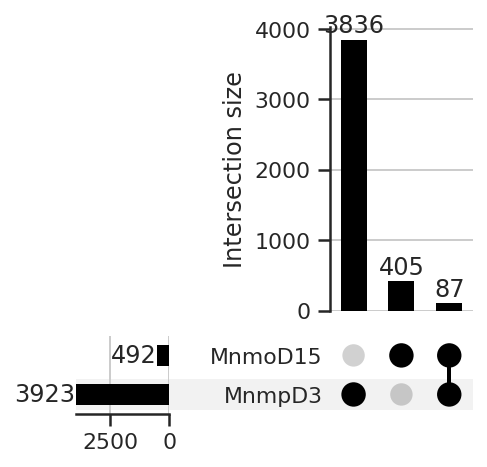

In [15]:
upset.plot(upset_df,show_counts=True,);

In [16]:
df = allele_table.groupby('subclone').agg({'sample':'nunique'})
cross_time_lineageGrp = df[df['sample'] > 1].index.to_list()
allele_table_linkage = allele_table[allele_table['subclone'].isin(cross_time_lineageGrp)].copy()

In [19]:
anno = pd.DataFrame()
for i in sampleid:
    tmp = adata_dict[i].obs[["orig.ident",'cell_type']].reset_index()
    anno = pd.concat([anno, tmp])

anno['sub_sample'] = anno['orig.ident']
anno['orig.ident'] = anno['orig.ident'].map({'MnmpD3':'MnmpD3', 'MnmoD7a':'MnmoD7', 'MnmoD7b':'MnmoD7',
                        'MnmoD15a':'MnmoD15', 'MnmoD15b':'MnmoD15','MnmoD15c':'MnmoD15'})
anno['index'] = [ ("_".join(row['index'].split('_')[0:2])) + "_" + row['sub_sample'] + "_" +  row['orig.ident'] if row['sub_sample'] != 'MnmpD3' else ("_".join(row['index'].split('_')[0:2])) + "_" +  row['orig.ident']  for index, row in anno.iterrows()]

In [23]:
allele_table_linkage = pd.merge(allele_table_linkage, anno, left_on='cellBC', right_on='index', how='inner')    

In [24]:
upset_df = upset.from_contents(allele_table_linkage[['sample','lineageGrp']].drop_duplicates().groupby('sample').agg({'lineageGrp':'unique'}).to_dict()['lineageGrp'])
idx = list(upset_df.loc[[(True, False, True), (False, True, True),(True, True, False),(True, True, True)]]['id'])
allele_table_linkage = allele_table_linkage[allele_table_linkage['subclone'].isin(idx)]

upset_df = upset.from_contents(allele_table_linkage[['sample','lineageGrp']].drop_duplicates().groupby('sample').agg({'lineageGrp':'unique'}).to_dict()['lineageGrp'])

In [34]:
import matplotlib as cm

sample_cols = dict(zip(sampleid, [cm.colors.rgb2hex(color) for color in plt.cm.get_cmap('Set2').colors[:3]]))

color_layers = {"sample" : sample_cols, "cell_type" : celltype_cols}

anno['sample_color'] = anno['orig.ident'].map(sample_cols)
anno['celltype_color'] = anno['cell_type'].map(celltype_cols)

## D3-D15

In [43]:
tmat = allele_table_linkage[allele_table_linkage['lineageGrp'].isin(list(upset_df.loc[[(True, False,True)]]['id']))] \
    .groupby(['lineageGrp', 'cell_type']) \
    .size().unstack()
tmat = (tmat.T / tmat.T.sum()).T

In [44]:
tmat = pd.DataFrame(tmat)
tmat_z = tmat
tmat_z = np.nan_to_num(tmat_z)

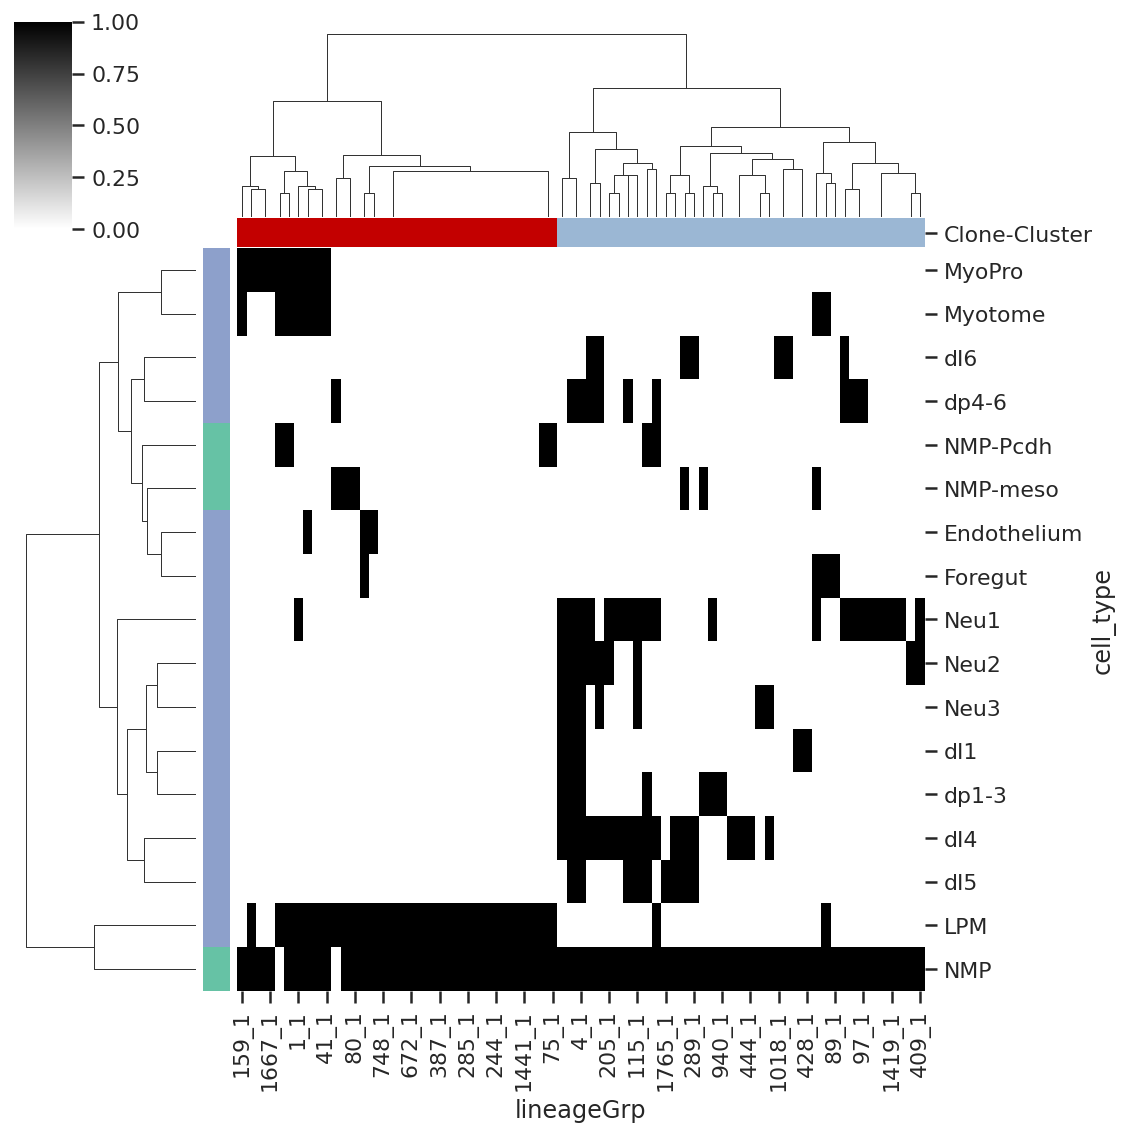

In [45]:
fate_to_color = {3: "#022e60",
                4: "#1cecdc",
                1: "#c30000",
                2: "#9bb7d4",
                5: "#efbc74"}

clone_hierarchy = scipy.cluster.hierarchy.linkage(
    scipy.spatial.distance.pdist(tmat_z > 0, metric='euclidean'), method='ward')

hierarchical_clusters = scipy.cluster.hierarchy.fcluster(clone_hierarchy, t=2, criterion="maxclust")

clone_to_cluster = {}
for i, clone in zip(range(len(tmat.index)), tmat.index):
    clone_to_cluster[clone] = hierarchical_clusters[i]
    
colors = pd.DataFrame.from_dict({clone: fate_to_color[clone_to_cluster[clone]] for clone in tmat.index},
                                orient='index', columns = ['Clone-Cluster'])

g = sns.clustermap(pd.DataFrame(tmat_z > 0, index = tmat.index, columns = tmat.columns).T,
               cmap = plt.cm.get_cmap('gray').reversed(), vmax=1, col_linkage=clone_hierarchy, method='ward', row_cluster=True,
               col_colors=colors['Clone-Cluster'],row_colors=tmat.columns.map(dict(anno[['cell_type','sample_color']].drop_duplicates().values)).to_list(),
               figsize=(8, 8), annot_kws={'font_size': 3}, yticklabels=True);
# plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=45)

## fate bais

In [46]:
state_cell = allele_table_linkage[allele_table_linkage['lineageGrp'].isin(tmat.index) & allele_table_linkage['sample'].isin(['MnmpD3'])][['cellBC','lineageGrp']].drop_duplicates()

state_cell['cluster'] = state_cell['lineageGrp'].map(clone_to_cluster)
state_cell['cellBC'] = [ "_".join(i.split("_")[:2]) for i in state_cell['cellBC']]

In [47]:
adata = adata_dict['MnmpD3'].copy()

adata.obs = pd.merge(adata.obs.reset_index(), state_cell, how='left', left_on="index",right_on='cellBC').set_index('index')

In [48]:
adata_filter = adata[-pd.isna(adata.obs.cellBC)]

adata_filter.obs['lineageGrp'] = adata_filter.obs['lineageGrp'].astype('int').astype('str')
adata_filter.obs['bias_cluster'] = adata_filter.obs['cluster'].map({1:"Meso_bias", 2:"Neu_bias"})

/tmp/ipykernel_677/82126931.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_filter.obs['lineageGrp'] = adata_filter.obs['lineageGrp'].astype('int').astype('str')


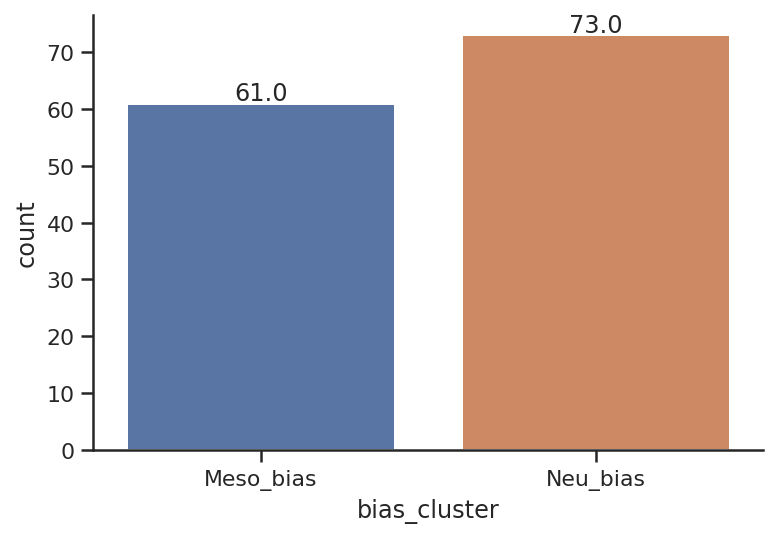

In [49]:
ax = sns.countplot(data=adata_filter.obs, x='bias_cluster', order=['Meso_bias','Neu_bias'])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

plt.show()

In [51]:
adata.obs = pd.merge(adata.obs, adata_filter.obs.bias_cluster, left_index=True, right_index=True, how='left')

In [52]:
def darken_cmap(cmap, scale_factor):
    """
    Generate a gradient color map for plotting.
    """

    cdat = np.zeros((cmap.N, 4))
    for ii in range(cdat.shape[0]):
        curcol = cmap(ii)
        cdat[ii, 0] = curcol[0] * scale_factor
        cdat[ii, 1] = curcol[1] * scale_factor
        cdat[ii, 2] = curcol[2] * scale_factor
        cdat[ii, 3] = 1
    cmap = cmap.from_list(cmap.N, cdat)
    return cmap

In [53]:
def customized_embedding(
    x,
    y,
    vector,
    title=None,
    ax=None,
    order_points=True,
    set_ticks=False,
    col_range=None,
    buffer_pct=0.03,
    point_size=1,
    color_map=None,
    smooth_operator=None,
    set_lim=True,
    vmax=None,
    vmin=None,
    color_bar=False,
    color_bar_label="",
    color_bar_title="",
):
    """
    Plot a vector on an embedding.

    Parameters
    ----------
    x: `np.array`
        x coordinate of the embedding
    y: `np.array`
        y coordinate of the embedding
    vector: `np.array`
        A vector to be plotted.
    color_map: {plt.cm.Reds,plt.cm.Blues,...}, (default: None)
    ax: `axis`, optional (default: None)
        An external ax object can be passed here.
    order_points: `bool`, optional (default: True)
        Order points to plot by the gene expression
    col_range: `tuple`, optional (default: None)
        The default setting is to plot the actual value of the vector.
        If col_range is set within [0,100], it will plot the percentile of the values,
        and the color_bar will show range [0,1]. This re-scaling is useful for
        visualizing gene expression.
    buffer_pct: `float`, optional (default: 0.03)
        Extra space for the plot box frame
    point_size: `int`, optional (default: 1)
        Size of the data point
    smooth_operator: `np.array`, optional (default: None)
        A smooth matrix to be applied to the subsect of gene expression matrix.
    set_lim: `bool`, optional (default: True)
        Set the plot range (x_limit, and y_limit) automatically.
    vmax: `float`, optional (default: np.nan)
        Maximum color range (saturation).
        All values above this will be set as vmax.
    vmin: `float`, optional (default: np.nan)
        The minimum color range, all values below this will be set to be vmin.
    color_bar: `bool`, optional (default, False)
        If True, plot the color bar.
    set_ticks: `bool`, optional (default, False)
        If False, remove figure ticks.

    Returns
    -------
    ax:
        The figure axis
    """

    from matplotlib.colors import Normalize as mpl_Normalize

    if color_map is None:
        color_map = darken_cmap(plt.cm.Reds, 0.9)
    if ax is None:
        fig, ax = plt.subplots()

    coldat = vector.astype(float)

    if smooth_operator is None:
        coldat = coldat.squeeze()
    else:
        coldat = np.dot(smooth_operator, coldat).squeeze()

    if order_points:
        o = np.argsort(coldat)
    else:
        o = np.arange(len(coldat))

    if vmin is None:
        if col_range is None:
            vmin = np.min(coldat)
        else:
            vmin = np.percentile(coldat, col_range[0])

    if vmax is None:
        if col_range is None:
            vmax = np.max(coldat)
        else:
            vmax = np.percentile(coldat, col_range[1])

    if vmax == vmin:
        vmax = coldat.max()

    ax.scatter(
        x[o], y[o], c=coldat[o], s=point_size, cmap=color_map, vmin=vmin, vmax=vmax
    )

    if not set_ticks:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis("off")

    if set_lim == True:
        ax.set_xlim(x.min() - x.ptp() * buffer_pct, x.max() + x.ptp() * buffer_pct)
        ax.set_ylim(y.min() - y.ptp() * buffer_pct, y.max() + y.ptp() * buffer_pct)

    if title is not None:
        ax.set_title(title)

    if color_bar:

        norm = mpl_Normalize(vmin=vmin, vmax=vmax)
        Clb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=color_map), ax=ax)
        Clb.set_label(
            color_bar_label,
            rotation=270,
            labelpad=20,
        )
        Clb.ax.set_title(color_bar_title)
    return ax

In [54]:
fig_width = 5
fig_height = 3.5
point_size = 3
x_emb = adata.obsm["X_umap"][:, 0]
y_emb = adata.obsm["X_umap"][:, 1]

(-11.246601953762044, 4.727554855091105, -7.703601434799948, 8.225077316191873)

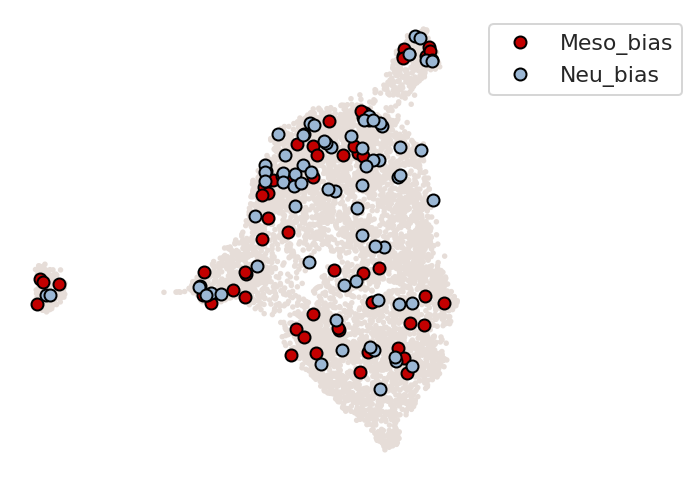

In [55]:
fig = plt.figure(figsize=(fig_width, fig_height))
ax = plt.subplot(1, 1, 1)

customized_embedding(
    x_emb,
    y_emb,
    np.zeros(len(y_emb)),
    ax=ax,
    point_size=point_size,
)

# color_list = ["red", "blue", "purple", "green", "cyan", "black"]
color_list = ["#c30000","#9bb7d4","#022e60","#1cecdc","#efbc74"]
legend_labels = adata.obs['bias_cluster'].cat.categories

for j, xx in enumerate(adata.obs['bias_cluster'].cat.categories):
    idx_clone = adata.obs['bias_cluster'] == xx
    ax.plot(
        x_emb[idx_clone],
        y_emb[idx_clone],
        ".",
        color=color_list[j % len(color_list)],
        markersize=12,
        markeredgecolor='black',
        markeredgewidth=1,
        label=legend_labels[j]
    )
    
ax.legend(bbox_to_anchor=(1.0, 1.0));
plt.tight_layout()
plt.axis('equal')

## clone_coupling

In [56]:
def merge_all(dict_of_data, 
              order=None, 
              batch_key='sample'
              ):
    """
    Merge the more than two sample datas
    
    Parameters:
    ----------
    dict_of_data: A dict contains more than two adata objects
    order:The order of Categorize variables,default:None
    batch_keys: The column name for each labels of the merged sample
    ----------
    Usage:
    -----
    import singleCellFunction as scf
    adata = scf.merge_all(dict_of_data=data)
    -----
    """
    if order is None:
        keys = list(dict_of_data.keys())
    else:
        keys = order
    adata = dict_of_data[keys[0]]
    adata = adata.concatenate([dict_of_data[i] for i in keys[1:]], batch_key=batch_key,join='outer')
    # Rename batch_key value
    rn = dict(zip([str(i) for i in range(len(keys))],keys))
    adata.obs[batch_key]=pd.Categorical(([rn[i] for i in adata.obs[batch_key].values]),categories=keys)
    return adata

In [57]:
adata_all = merge_all(adata_dict,batch_key='sample')

In [58]:
adata_all.obs['cell_type'] = adata_all.obs['cell_type'].astype('category')
adata_all.obs['cell_type'] = adata_all.obs['cell_type'].cat.set_categories(list(celltype_cols.keys()), ordered=True)
adata_all.uns['cell_type_colors'] = [celltype_cols[i] for i in adata_all.obs['cell_type'].astype('category').cat.categories]

In [60]:
df = adata_all.obs.reset_index()
df['index'] = [ "_".join(row['index'].split('-')[0].split("_")[0:2]) + "_" + row['orig.ident'] + "_" +  row['sample'] 
 if row['sample'] != 'MnmpD3' else row['index'].split('-')[0] + "_" +  row['orig.ident']
 for index, row in adata_all.obs.reset_index().iterrows()]

adata_all.obs = df.set_index('index')

In [63]:
import cospar as cs

In [64]:
adata_all.obs = pd.merge(adata_all.obs.reset_index(), allele_table[['cellBC','lineageGrp']].drop_duplicates(), left_on='index',right_on='cellBC', how='left').set_index('index')

In [65]:
df_X_clone = adata_all.obs.reset_index()[['index', 'lineageGrp']]
df_X_clone = df_X_clone.dropna()
df_X_clone['lineageGrp'] = df_X_clone['lineageGrp'].astype(str)
X_clone_order = pd.DataFrame({'order' : range(len(df_X_clone['lineageGrp'].unique())), 'clone' : df_X_clone['lineageGrp'].unique()})

In [66]:
cs.pp.get_X_clone(adata_all, list(df_X_clone["index"]), list(df_X_clone["lineageGrp"]), reference_clone_id = list(X_clone_order['clone']))

100%|██████████| 11646/11646 [00:00<00:00, 748679.79it/s]


In [67]:
X_emb = np.array([adata_all.obsm['X_umap'][:,0], adata_all.obsm['X_umap'][:,1]]).T

In [68]:
adata_orig = cs.pp.initialize_adata_object(
    X_state=adata_all.X,
    gene_names=adata_all.var_names.format(),
    cell_names=adata_all.obs_names.format(),
    time_info=adata_all.obs['sample'],
    X_clone=adata_all.obsm['X_clone'],
    state_info=adata_all.obs["cell_type"],
    X_emb=X_emb,
    X_pca=adata_all.obsm['X_pca'],
    data_des="Mnmo",
)

Create new anndata object
Time points with clonal info: ['MnmoD15' 'MnmoD7' 'MnmpD3']


In [69]:
cs.hf.update_time_ordering(adata_orig, updated_ordering=['MnmpD3','MnmoD7','MnmoD15'])

In [87]:
coarse_X_clone, fate_names = cs.tl.coarse_grain_clone_over_cell_clusters(adata_orig, 
                                            selected_times=['MnmpD3','MnmoD15'],
                                            selected_fates=['LPM','dI1','Neu4','Endothelium','Myotome','Neu3','dI5','MyoPro','dp1-3','dI6','Foregut','dI4','Neu2','Neu1','dp4-6'],
                                            normalize=True
                                           )

normalize by X_clone
each cluster do not have a unique time point. Simply column-normalize the matrix


In [88]:
exclude_idx = coarse_X_clone.sum(1) == 0
if np.any(exclude_idx):
    coarse_X_clone = coarse_X_clone[~exclude_idx]
    fate_names = np.array(fate_names)[~exclude_idx]

In [89]:
data = np.array(coarse_X_clone) > 0
X = scipy.spatial.distance.cdist(data, data, metric='jaccard')
X_coupling = 1 - X

Text(0.5, 1.0, 'Clonal coupling score')

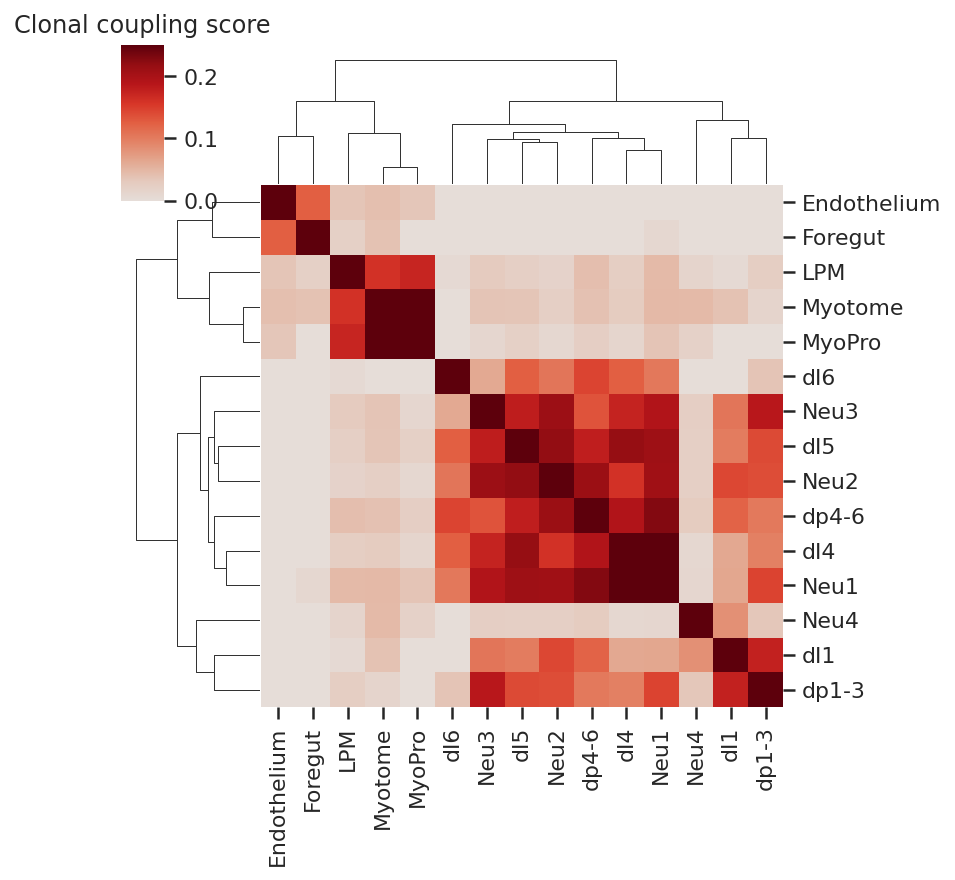

In [93]:
df = pd.DataFrame(X_coupling,
             index=fate_names,
             columns=fate_names)

g = sns.clustermap(df, cmap=darken_cmap(plt.cm.Reds, scale_factor=0.9),
                   method='ward', metric='correlation',
                   yticklabels=True, xticklabels=True,
                   vmax=0.25,
                   figsize=(6, 6))
plt.title('Clonal coupling score')